In [1]:
#imports 
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim

from PIL import Image

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from nltk.corpus import stopwords

from torchvision.models import resnet50, ResNet50_Weights
import torch
import datetime

import sys
sys.path.append('../src')
from utils import Vocabulary, FlickrDataset, CapsCollate, show_image, EncoderDecoder, DecoderRNN

import wandb

image_path = "../all_images/Flicker8k_Dataset/" 
train_file_path = '../all_captions/Flickr_8k.trainImages.txt'
captions_path = "../all_captions/Flickr8k.token.txt"
test_file_path = '../all_captions/Flickr_8k.testImages.txt'
run = datetime.datetime.now().strftime('%b-%d-%H-%M-%S')
MODEL_SAVE_PATH = '../models/resnet-50-' + run + '.pth'
TRACKING_DICT_PATH = '../models/tracking-' + run + '.csv'

c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
torch.cuda.is_available()

True

In [3]:
MODEL_SAVE_PATH

'../models/resnet-50-Mar-01-17-35-03.pth'

In [4]:
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [5]:
#testing the vicab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [6]:
def clean_text(text):
  text = text.lower()
  text = re.sub("[^a-z]+", " ", text)
  text = text.split()
  text = [s for s in text if len(s)> 1]
  text = " ".join(text)
  return text

caption_file = open(captions_path, "r").read()

keys = []
caption_list = []

for row in caption_file.split("\n"):
    key = row.split("#")[0].split(".")[0]
    caption = row.split("#")[-1].split("\t")[-1]
    caption = caption.replace('.', '')
    caption = clean_text(caption)

    keys.append(key)
    caption_list.append(caption)

captions = pd.DataFrame(data=zip(keys, caption_list), columns=["image", "caption"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


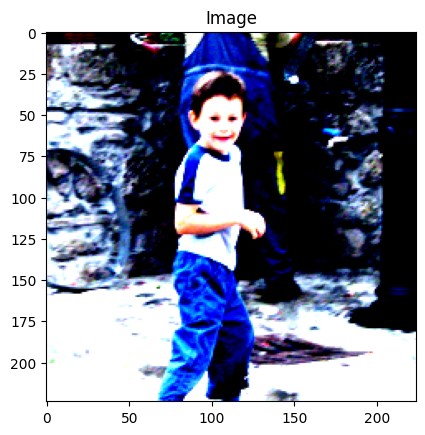

Image shape:  torch.Size([3, 224, 224])
Token:  tensor([  1,  75, 148, 130, 156,  24,  47,   2])
Sentence: 
['<SOS>', 'young', 'boy', 'runs', 'aross', 'the', 'street', '<EOS>']


In [7]:
transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )])
dataset = FlickrDataset("../all_images/Flicker8k_Dataset", captions, transform=transform, freq_threshold=1)
img, caps = dataset[42]
show_image(img, "Image")
print("Image shape: ", img.shape)
print("Token: ", caps)
print("Sentence: ")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [8]:
BATCH_SIZE = 512
NUM_WORKERS = 0
frequency_threshold = 1

transform = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
            )])

def my_collate_fn(batch):
    images_ = list()
    captions_ = list()

    for b in batch:
        images_.append(b[0])
        captions_.append(b[1])

    images_ = torch.stack(images_, dim=0)
    captions_ = pad_sequence(captions_, batch_first=True, padding_value=0)

    return images_, captions_

#reset index to make dataloader indexing work
train_file = open(train_file_path, 'r').read()
train_imgs = [row.split(".")[0] for row in train_file.split("\n")[:-1]]
train_data = captions[captions.image.isin(train_imgs)]
train_data = train_data.reset_index()

test_file = open(test_file_path, 'r').read()
test_imgs = [row.split(".")[0] for row in test_file.split("\n")[:-1]]
test_data = captions[captions.image.isin(test_imgs)]
test_data = test_data.reset_index()


vocab = Vocabulary(frequency_threshold)
vocab.build_vocab(captions.caption.tolist())

train_dataset = FlickrDataset("../all_images/Flicker8k_Dataset", train_data, transform=transform, vocab=vocab)
test_dataset = FlickrDataset("../all_images/Flicker8k_Dataset", test_data, transform=transform, vocab=vocab)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=CapsCollate())
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=CapsCollate())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
embed_size = 300
vocab_size = len(vocab)
attention_dim = 1024
encoder_dim = 2048
decoder_dim = 1024
learning_rate = 0.01

model = EncoderDecoder(embed_size = embed_size, 
    vocab_size = vocab_size, 
    attention_dim = attention_dim, 
    encoder_dim = encoder_dim, 
    decoder_dim = decoder_dim, 
    device = device).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="show-attend-tell",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "show-attend-tell",
    "dataset": "flickr8k",
    "epochs": 20,
    "resnet50": "pretrained two layers unfrozen"
    }
)

c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jaguar (22hs_i4ds20). Use `wandb login --relogin` to force relogin


In [10]:
num_epochs = 25
print_every = 100

tracking_dict = {"train_loss": [], "img_loading_time": [], "training_time": [], "validation_loss": [], "validation_time": [], "epoch": [], "epoch_time": []}

# Creates a GradScaler once at the beginning of training.
scaler = torch.cuda.amp.GradScaler()

for epoch in range(1, num_epochs + 1):
    start = time()
    data_loading_time = 0
    model.train()
    for idx, (imgs, caps) in enumerate(iter(train_dataloader)):
        torch.cuda.empty_cache()
        data_loading_time += time() - start
        imgs = imgs.to(device)
        caps = caps.to(device)

        optimizer.zero_grad()
        
                # Runs the forward pass with autocasting.
        with torch.autocast(device_type='cuda', dtype=torch.float16): 
            outputs, attentions = model(imgs, caps)
            targets = caps[:, 1:]
            train_loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        scaler.scale(train_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.step()

        if idx % print_every == 0:
            print(f"Train Epoch: {epoch} | Step: {idx} | Loss: {train_loss.item():.4f}")
    
    training_time = time() - start
    print(f"Epoch: {epoch} | Time: {time() - start:.2f} seconds")
    tracking_dict["train_loss"].append(train_loss.item())
    tracking_dict["img_loading_time"].append(data_loading_time/len(train_dataloader))
    tracking_dict["training_time"].append(training_time)

    # validation
    start_val = time()
    model.eval()
    with torch.no_grad():
        for idx, (imgs, caps) in enumerate(iter(test_dataloader)):
            imgs = imgs.to(device)
            caps = caps.to(device)

            outputs, attentions = model(imgs, caps)
            targets = caps[:, 1:]
            val_loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

            if idx % print_every == 0:
                print(f"Validation Epoch: {epoch} | Step: {idx} | Loss: {val_loss.item():.4f}")
    
    validation_time = time() - start_val
    print(f"Epoch: {epoch} | Time: {time() - start_val:.2f} seconds")
    tracking_dict["validation_loss"].append(val_loss.item())
    tracking_dict["validation_time"].append(validation_time)
    tracking_dict["epoch"].append(epoch)
    tracking_dict["epoch_time"].append(time() - start)

    # wandb logging
    # log metrics to wandb
    wandb.log({"train_loss": train_loss.item(), "img_loading_time": data_loading_time/len(train_dataloader), "training_time": training_time, "validation_loss": val_loss.item(), "validation_time": validation_time, "epoch": epoch, "epoch_time": time() - start})

torch.save(model.state_dict(), MODEL_SAVE_PATH)
tracking_dict = pd.DataFrame(tracking_dict)
tracking_dict.to_csv(TRACKING_DICT_PATH)

Train Epoch: 1 | Step: 0 | Loss: 9.0535
Epoch: 1 | Time: 320.51 seconds
Validation Epoch: 1 | Step: 0 | Loss: 5.2363
Epoch: 1 | Time: 40.46 seconds
Train Epoch: 2 | Step: 0 | Loss: 5.3207
Epoch: 2 | Time: 321.28 seconds
Validation Epoch: 2 | Step: 0 | Loss: 4.9758
Epoch: 2 | Time: 41.88 seconds
Train Epoch: 3 | Step: 0 | Loss: 4.9144
Epoch: 3 | Time: 316.33 seconds
Validation Epoch: 3 | Step: 0 | Loss: 5.2507
Epoch: 3 | Time: 41.21 seconds
Train Epoch: 4 | Step: 0 | Loss: 4.8567
Epoch: 4 | Time: 320.52 seconds
Validation Epoch: 4 | Step: 0 | Loss: 4.7934
Epoch: 4 | Time: 40.45 seconds
Train Epoch: 5 | Step: 0 | Loss: 4.7170
Epoch: 5 | Time: 316.98 seconds
Validation Epoch: 5 | Step: 0 | Loss: 5.0507
Epoch: 5 | Time: 40.03 seconds
Train Epoch: 6 | Step: 0 | Loss: 4.7188
Epoch: 6 | Time: 316.69 seconds
Validation Epoch: 6 | Step: 0 | Loss: 5.0915
Epoch: 6 | Time: 40.54 seconds
Train Epoch: 7 | Step: 0 | Loss: 4.7308
Epoch: 7 | Time: 305.97 seconds
Validation Epoch: 7 | Step: 0 | Loss: 5.

In [14]:
wandb.finish()

In [12]:
len(test_data)

5000

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

0